# Preprocessing

In [1]:
import numpy as np
import spacy
import gensim
import os
import re
from gensim import corpora
from nltk.tokenize import sent_tokenize
import pandas as pd
nlp = spacy.load("en_core_web_md")

In [2]:
from bs4 import BeautifulSoup
from os import mkdir
import requests
#Dicitionary used to access full book text in HTML format
urls = {'foucault_madness_and_civ':'https://archive.org/stream/Michel_Foucault_Madness_And_Civilization/Michel%20Foucault%2C%20Richard%20Howard%20%28transl.%29%20-%20Madness%20and%20Civilization_%20A%20History%20of%20Insanity%20in%20the%20Age%20of%20Reason%20%282013%2C%20Vintage%29_djvu.txt',
        'foucault_discipline_and_punish': 'https://archive.org/stream/MichelFoucaultDisciplineAndPunish/Michel%20Foucault%20-%20Discipline%20and%20Punish_djvu.txt',
        'foucault_history_of_sexuality':'https://archive.org/stream/TheHistoryOfSexualityVol13/The-History-Of-Sexuality-Vol-1-3_djvu.txt',
        'chomsky_media_control': 'https://archive.org/stream/media_Noam_Chomsky-Media_Control/Noam_Chomsky-Media_Control_djvu.txt',
        'chomsky_american_power': 'https://archive.org/stream/AmericanPowerAndTheNewMandarins_201805/American%20Power%20And%20The%20New%20Mandarins_djvu.txt',
        'chomsky_manufacturing_consent': 'https://archive.org/stream/revhosatx14/%5BEdward_S._Herman%2C_Noam_Chomsky%5D_Manufacturing_Con%28b-ok.org%29_djvu.txt'}

In [3]:
def file_books(title, link):
    '''Create directories for book from title and link'''
    #Access HTML webpage on Internet Archive
    r = requests.get(link)
    data = r.text
    soup = BeautifulSoup(data)
    #Full text is in <pre> part of HTML doc
    book = soup.pre.string
    #Write book as text file, save file
    with open(f'./data/{title}.txt', 'w', encoding='utf-8') as book_file:
        book_file.write(book)
        #Make a folder for each book
        mkdir(f'./data/{title}_extracts')
def split_book(title, n_lines=5):
    '''Split a text file based on a number of lines, book title'''
    #Find file path based on title
    filepath = f'./data/{title}.txt'
    #Extract directory and filename from file path
    path, filename = os.path.split(filepath)
    #Change path to book's directory
    path += f'/{title}_extracts'
    # filename.split('.') would not work for filenames with more than one .
    basename, ext = os.path.splitext(filename)
    #open input file
    with open(filepath, 'r', encoding='utf-8') as book_file:
        try:
            #open the first output(extract) file
            extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, 0, ext)), 'w', encoding='utf-8')
            #Loop over all lines of input file, number them
            for i, sentence in enumerate(sent_tokenize(book_file.read())):
                #Close extract file and open a new one
                #When the line number % desired n_lines is 0
                if i % n_lines == 0:
                    extract_file.close()
                    #Open the next output file to write the next extract
                    extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, i/100, ext)), 'w', encoding='utf-8')
                #write the line to extract file
                extract_file.write(sentence)
        finally:
            #close last output file
            extract_file.close()

In [4]:
if not os.path.isdir('./data'):  
    os.mkdir('./data')
for title, link in urls.items():
    if not os.path.isdir(f'./data/{title}_extracts'):
        file_books(title, link)
        split_book(title)

In [5]:
def gather_data(path_to_data):
    path = f'./data/{path_to_data}'
    data = {'extracts': [], 'author': []}
    #For file at the given path
    for file in os.listdir(path):
        #If the directory is not a folder
        if os.path.isdir(file) == False:
            #If the file type is .txt
            if file[-3:] == 'txt':
                #Open each text file at the path provided
                with open(os.path.join(path, file), encoding='utf-8') as t:
                    #Read and strip new line signal
                    text = t.read().replace('\n', ' ')
                    data['extracts'].append(str(text))
                    data['author'].append(path_to_data.split('_')[0])
    return data

In [6]:
extracts_dirs = [folder for folder in os.listdir('./data') if (os.path.isdir(f'./data/{folder}') == True)]

In [7]:
df_final = pd.DataFrame({'extracts': [], 'author': []})
for directory in extracts_dirs:
    extracts = gather_data(directory)
    df = pd.DataFrame(extracts, columns = extracts.keys())
    df_final = pd.concat([df_final, df], axis=0)
print(df_final.shape)
df_final = df_final.reset_index()

(5725, 2)


In [8]:
df_final = df_final[df_final['author'] != '.ipynb']
df_final['author'].value_counts()

foucault    3290
chomsky     2434
Name: author, dtype: int64

In [94]:
import pickle
file = open(f'./data/dataframe.pkl', 'wb')
pickle.dump(df_final, file)
file.close()

# Model

## Train/Test Split

In [9]:
from sklearn.model_selection import train_test_split
X = df_final['extracts']
y = df_final['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## Randomized Search w/ Naive Bayes

In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from gensim.parsing.preprocessing import preprocess_string
# from sklearn.pipeline import Pipeline
counter = TfidfVectorizer(
                          stop_words='english',
                          tokenizer=preprocess_string)

rf = RandomForestClassifier()
nb = MultinomialNB()
rusampler = RandomUnderSampler()

In [38]:
pipeline = Pipeline([('counter', counter),
                     ('sampler', rusampler),
                     ('bayes', nb)])
parameters = {
    'counter__max_df': [i/100 for i in range(75, 100)],
    'counter__min_df': range(0, 10),
    'counter__ngram_range': [(1,2), (1, 3), (2,3), (3, 6), (2, 7)],
    'counter__analyzer': ['word', 'char', 'char_wb']
}

rand_search = RandomizedSearchCV(pipeline, parameters, cv=2, n_iter=8, n_jobs=1, verbose=2)

In [39]:
best = rand_search.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] counter__ngram_range=(2, 7), counter__min_df=6, counter__max_df=0.8, counter__analyzer=char 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  counter__ngram_range=(2, 7), counter__min_df=6, counter__max_df=0.8, counter__analyzer=char, total=  43.9s
[CV] counter__ngram_range=(2, 7), counter__min_df=6, counter__max_df=0.8, counter__analyzer=char 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.8s remaining:    0.0s


[CV]  counter__ngram_range=(2, 7), counter__min_df=6, counter__max_df=0.8, counter__analyzer=char, total=  45.7s
[CV] counter__ngram_range=(3, 6), counter__min_df=5, counter__max_df=0.91, counter__analyzer=char 
[CV]  counter__ngram_range=(3, 6), counter__min_df=5, counter__max_df=0.91, counter__analyzer=char, total=  24.9s
[CV] counter__ngram_range=(3, 6), counter__min_df=5, counter__max_df=0.91, counter__analyzer=char 
[CV]  counter__ngram_range=(3, 6), counter__min_df=5, counter__max_df=0.91, counter__analyzer=char, total=  28.5s
[CV] counter__ngram_range=(1, 2), counter__min_df=6, counter__max_df=0.88, counter__analyzer=char 
[CV]  counter__ngram_range=(1, 2), counter__min_df=6, counter__max_df=0.88, counter__analyzer=char, total=   4.2s
[CV] counter__ngram_range=(1, 2), counter__min_df=6, counter__max_df=0.88, counter__analyzer=char 
[CV]  counter__ngram_range=(1, 2), counter__min_df=6, counter__max_df=0.88, counter__analyzer=char, total=   4.0s
[CV] counter__ngram_range=(1, 3), c

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  4.3min finished


In [40]:
best.best_estimator_.score(X_val, y_val)

0.98545101842871

In [41]:
best.best_estimator_.score(X_test, y_test)

0.9825479930191972

In [42]:
best.best_estimator_.predict_proba([''])

array([[0.5, 0.5]])

In [43]:
import pickle 
filename = './models/nb_model.pkl'
file = open(filename, 'wb')
pickle.dump(best, file)
file.close()

In [290]:
file = open('./models/nb_model.pkl', 'rb')
nb = pickle.load(file)
file.close()

# Word Embeddings with Spacy

In [12]:
def get_doc_vectors(words):
    # converts a list of words into their word vectors
    return nlp(words).vector

In [13]:
get_doc_vectors('')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [15]:
vectors = df_final['extracts'].apply(get_doc_vectors).tolist()

In [16]:
from sklearn.decomposition import PCA
import pickle
pca = PCA(2)
word_vecs_2d = pca.fit_transform(vectors)

In [17]:
word_vecs_train = X_train.apply(get_doc_vectors).tolist()
word_vecs_val = X_val.apply(get_doc_vectors).tolist()
word_vecs_test = X_test.apply(get_doc_vectors).tolist()

In [18]:
#Pickle 2D word vectors for use in dash app
file = open(f'./models/word_vectors.pkl', 'wb')
pickle.dump(word_vecs_2d, file)
file.close()

In [19]:
get_doc_vectors('no')

array([-0.14121  ,  0.034641 , -0.443    , -0.093265 , -0.010022 ,
       -0.069041 ,  0.16335  , -0.12964  ,  0.0045672,  2.3127   ,
       -0.12048  ,  0.054694 , -0.22722  ,  0.059882 , -0.28076  ,
       -0.2715   ,  0.17744  ,  1.4719   ,  0.14243  ,  0.25179  ,
        0.039256 , -0.19574  ,  0.25275  , -0.12224  , -0.23064  ,
       -0.0449   ,  0.18679  , -0.27084  ,  0.67684  , -0.13295  ,
        0.13029  ,  0.2128   , -0.25393  , -0.34708  , -0.013974 ,
        0.17852  ,  0.16488  ,  0.080326 ,  0.029319 , -0.56489  ,
       -0.17003  ,  0.20811  ,  0.43094  ,  0.2132   ,  0.26778  ,
        0.063854 , -0.23329  ,  0.18415  ,  0.14159  ,  0.10566  ,
        0.042333 ,  0.16718  ,  0.14764  ,  0.051008 ,  0.07869  ,
        0.29462  , -0.031126 , -0.024006 , -0.13177  , -0.38212  ,
        0.049503 ,  0.08338  ,  0.17229  ,  0.10892  ,  0.40207  ,
        0.16887  ,  0.20803  , -0.16576  , -0.10935  ,  0.25171  ,
        0.2537   ,  0.12471  , -0.065506 ,  0.11825  , -0.0830

In [20]:
pipeline.steps[1][1].kneighbors()[1]

NameError: name 'pipeline' is not defined

In [23]:
from imblearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
for k in range(1,50):
    pca = PCA(2)
    knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors = k, weights='distance', metric='euclidean')
    pipeline = make_pipeline(pca, rusampler, knn)
    pipeline.fit(word_vecs_train, y_train)
    new_obs_2d = pipeline.named_steps['pca'].transform(get_doc_vectors('').reshape(1, -1))
    print(k, pipeline.score(word_vecs_test, y_test), 
#           pipeline.steps[1][1].kneighbors(new_obs_2d),
          pipeline.predict_proba(get_doc_vectors('').reshape(1, -1)))

1 0.7347294938917975 [[1. 0.]]
2 0.7469458987783595 [[0.5 0.5]]
3 0.7853403141361257 [[0.66666667 0.33333333]]
4 0.794066317626527 [[0.5 0.5]]
5 0.8045375218150087 [[0.49999995 0.50000005]]
6 0.8115183246073299 [[0.66666651 0.33333349]]
7 0.8045375218150087 [[0.4999996 0.5000004]]
8 0.8167539267015707 [[0.66666666 0.33333334]]
9 0.8132635253054101 [[0.66666516 0.33333484]]
10 0.8132635253054101 [[0.49999929 0.50000071]]
11 0.8272251308900523 [[0.6666653 0.3333347]]
12 0.8167539267015707 [[0.49999419 0.50000581]]
13 0.8184991273996509 [[0.66666595 0.33333405]]
14 0.8132635253054101 [[0.49999965 0.50000035]]
15 0.8289703315881326 [[0.66666397 0.33333603]]
16 0.8150087260034904 [[0.49999991 0.50000009]]
17 0.8167539267015707 [[0.4999991 0.5000009]]
18 0.8167539267015707 [[0.49999765 0.50000235]]
19 0.8150087260034904 [[0.49999991 0.50000009]]
20 0.8219895287958116 [[0.66666224 0.33333776]]
21 0.8254799301919721 [[0.49998692 0.50001308]]
22 0.8272251308900523 [[0.49999732 0.50000268]]
23 0

In [24]:
pca = PCA(2)
k=2
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors = k, weights='distance', metric='euclidean')
pipeline = make_pipeline(pca, knn)
pipeline.fit(word_vecs_train, y_train)
file = open(f'./models/model_k{k}.pkl', 'wb') # 2 is most balanced prediction probabilities
pickle.dump(pipeline, file)
file.close()

In [ ]:
pipeline.named_steps

In [280]:
def display_results(text):
    file = open(f'./models/model_k{49}.pkl', 'rb')
    model = pickle.load(file)
    file.close()
    vector = get_doc_vectors(text)
    new_obs = vector.reshape(1, -1)
    print(new_obs.shape)
    new_obs_2d = model.named_steps['pca'].transform(new_obs)
    index = model.named_steps['kneighborsclassifier'].kneighbors(new_obs_2d)[1][0][0]
    text = df['extracts'][index]
    return f'The author most likely to have written your sample, "{text}", is {index}.'

display_results('Noam Chomsky was a great author')

(1, 300)


'The author most likely to have written your sample, "This structure proper to the monarchical and bourgeois order  of France, contemporary with its organization in absolutist  forms, soon extended its network over the whole of France. An  edict of the King, dated June 16, 1676, prescribed the  establishment of an “hopital general in each city of his kingdom.”  Occasionally the measure had been anticipated by the local  authorities; the bourgeoisie of Fyons had already organized in  1612 a charity establishment that functioned in an analogous  manner. The Archbishop of Tours was proud to declare on July  10, 1676, that his “archepiscopal city has happily foreseen the  pious intentions of the King and erected an hopital general called  Fa Charite even before the one in Paris, whose order has served  as a model for all those subsequently established, within or  outside the kingdom.” The Charite of Tours, in fact, had been  founded in 1656, and the King had endowed it with an income  of f

In [25]:
plt.scatter(x=word_vecs_2d[:, 0],y=word_vecs_2d[:,1])

NameError: name 'plt' is not defined

Text(0.5, 1.0, '')

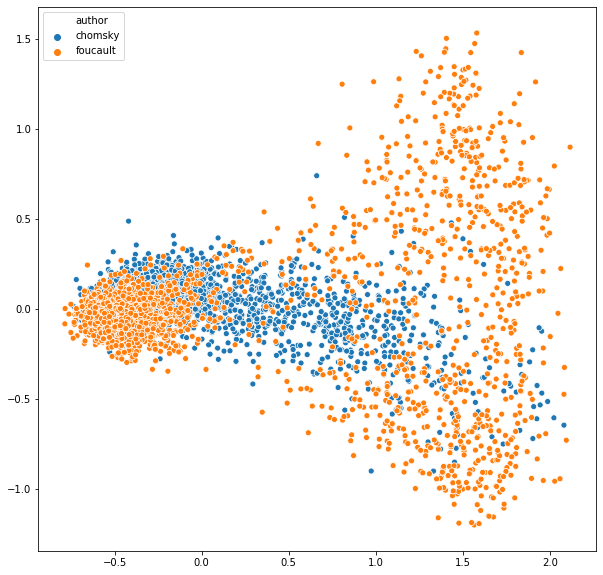

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.scatterplot(word_vecs_2d[:,0], word_vecs_2d[:,1], hue=df_final['author'])
plt.title('')

# Word Embeddings w/ Gensim

In [33]:
from gensim.test.utils import common_texts
from gensim.utils import  simple_preprocess, lemmatize
preprocess_string(df_final['extracts'][3])

['ililpiigpilffifipi',
 'rwm',
 'tret',
 'skss',
 '£i',
 'binf',
 'ifflh',
 'hii',
 'ihhl',
 'swa']

In [1]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

In [137]:
def read_corpus(series, tokens_only=False):
    for i, doc in enumerate(series):
        tokens = gensim.utils.simple_preprocess(doc)
        print(tokens)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [149]:
next(read_corpus(df_final['extracts']))

['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii']


TaggedDocument(words=['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii'], tags=[0])